In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import matlib
import seaborn as sns
from PyalData.pyaldata.interval import restrict_to_interval 
from numpy.linalg import eig



In [2]:
orig_df = pd.read_pickle('Test_OutputUnrestricted.pkl')
preparatory_rates = restrict_to_interval(orig_df,"idx_trial_start","idx_go_cue",0,0,None,None,None,False, True, 'motor_cortex_rates')
movement_rates = restrict_to_interval(orig_df,"idx_go_cue","idx_trial_end",0,0,None,None,None,False, True, 'motor_cortex_rates')

PREPARATION
<\n> preprates is an n x ct matrix where n is the number of neurons, c is the number of targets and t is the number of timestamps.

In [3]:

for i in range(8):

    if i == 0:
        preptarget = preparatory_rates.loc[preparatory_rates.target_id == i]
        averagetargetrates = np.transpose(preptarget['motor_cortex_rates'].mean())
        preprates = averagetargetrates
    else:
        preptarget = preparatory_rates.loc[preparatory_rates.target_id == i]
        averagetargetrates = np.transpose(preptarget['motor_cortex_rates'].mean())
        preprates = np.concatenate((preprates, averagetargetrates), axis=1)


preprates

array([[0.        , 0.        , 0.        , ..., 0.70819324, 0.7143995 ,
        0.71948224],
       [0.22403456, 0.22736557, 0.2305753 , ..., 0.626934  , 0.63385963,
        0.6430361 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15755431, 0.15983197, 0.16195324, ..., 0.        , 0.        ,
        0.        ],
       [0.05805849, 0.0586075 , 0.05937155, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

MOVEMENT
Movementrates is an n x ct matrix where n is the number of neurons, c is the number of targets and t is the number of timestamps.

In [4]:
for i in range(8):

    if i == 0:
        movetarget = movement_rates.loc[movement_rates.target_id == i]
        averagetargetrates =  np.transpose(movetarget['motor_cortex_rates'].mean())
        movementrates = averagetargetrates
    else:
        movetarget = movement_rates.loc[movement_rates.target_id == i]
        averagetargetrates = np.transpose(movetarget['motor_cortex_rates'].mean())
        movementrates = np.concatenate((movementrates, averagetargetrates), axis=1)

movementrates.shape

(50, 648)

FINDING COVARIANCE MATRIX

In [5]:
#Find covariance matrix
mean_prep = np.mean(preprates, axis = 1)
mean_move = np.mean(movementrates, axis = 1)
mean_prep = np.transpose(np.matlib.repmat(mean_prep,648,1))
mean_move = np.transpose(np.matlib.repmat(mean_move,648,1))

transformed_prep = preprates - mean_prep
transformed_move = movementrates - mean_move


covarianceprep = (1/(transformed_prep.shape[0]*transformed_prep.shape[1]))*np.matmul(transformed_prep,np.transpose(transformed_prep))
covariancemove = (1/(transformed_move.shape[0]*transformed_move.shape[1]))*np.matmul(transformed_move,np.transpose(transformed_move))


In [6]:
def find_variance(eigenvalues):
    total = sum(eigenvalues)
    for i in range(len(eigenvalues)):
        eigenvalues[i] = (eigenvalues[i]/total)*100
    
    return eigenvalues

PRINCIPAL COMPONENTS ANALYSIS

In [7]:
# Finding eigenvectors and eigenvalues of Covariance Matrix
val_prep, pc_prep = eig(covarianceprep)
val_move, pc_move = eig(covariancemove)

variance_prep = find_variance(val_prep)
variance_prep = variance_prep[:10]

variance_move = find_variance(val_move)
variance_move = variance_move[:10]

# Project data to opposite epoch
#top10_pcprep = pc_prep[:,:10]

# Transform movement data into top 10 prep PC dimensions
projected_movement = np.matmul(np.transpose(pc_prep), transformed_move)
proj_movementsquared = np.square(projected_movement)
proj_column = np.sum(proj_movementsquared, axis = 1)
proj_movementvar = (1/(projected_movement.shape[0]*projected_movement.shape[1]))*proj_column
proj_movementvar.shape

proj_variance_move = find_variance(proj_movementvar)
proj_variance_move = proj_variance_move[:10]

print(proj_variance_move)




[42.282005   18.011099    1.8723093   1.2269182   2.3092291   2.8321054
  2.3507118   0.43304363  2.8079207   0.17308447]


PLOT OUT GRAPHS

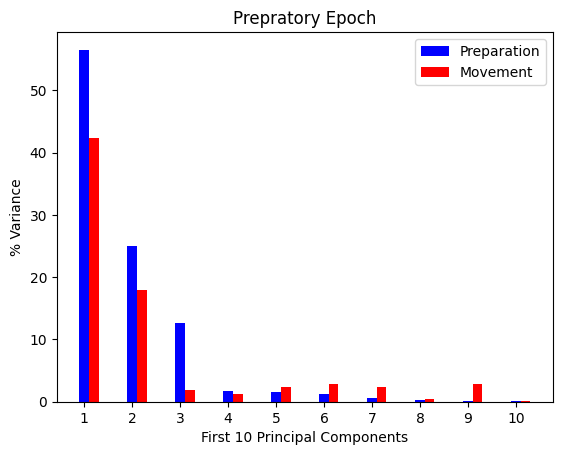

In [12]:
x_axis = np.array([1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])
width = 0.2
plt.bar(x_axis, variance_prep, width=0.2, color='b', align='center')
plt.bar(x_axis + width, proj_variance_move, width=0.2, color='r', align='center')
plt.title('Prepratory Epoch')
plt.xlabel('First 10 Principal Components')
plt.ylabel('% Variance')
plt.xticks(x_axis)
plt.legend(['Preparation', 'Movement'])
plt.show()